In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.rcParams['figure.figsize'] = (12, 8)

#Load text file 

def load_log(file, base = '../logs/'):
    results = []
    with open(base + file) as f:
        for line in f:
            if '* Prec@1' in line: 
                line = line.split()
                results.append(float(line[-1]))
    return results

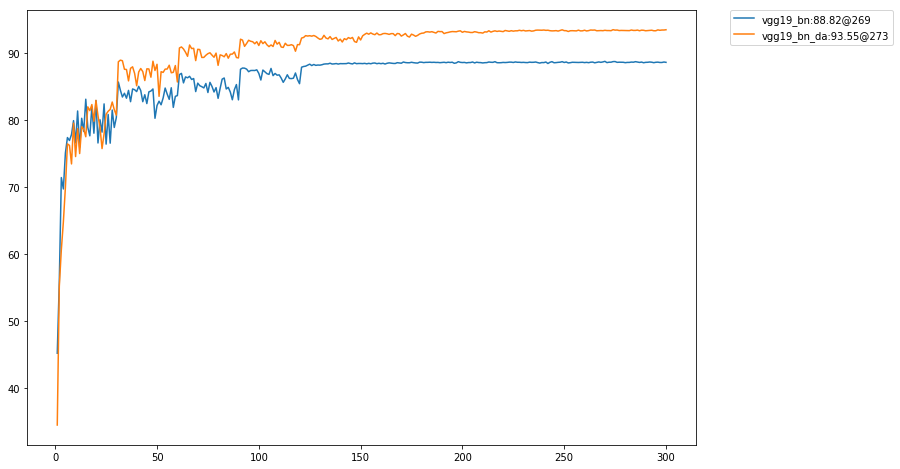

In [2]:
shows = {}
shows['vgg19_bn'] = load_log('log_vgg19_bn')
shows['vgg19_bn_da'] = load_log('../log_da_vgg19_bn')
# shows['vgg11_half'] = load_log('log_half_vgg11')
#shows['vgg11_bn'] = load_log('log_vgg11_bn')
#shows['vgg11_half_bn'] = load_log('log_half_vgg11_bn')

# shows['vgg13'] = load_log('log_vgg13')
# shows['vgg13_half'] = load_log('log_half_vgg13')
#shows['vgg13_bn'] = load_log('log_vgg13_bn')
#shows['vgg13_half_bn'] = load_log('log_half_vgg13_bn')

#epochs = np.arange(1,1+len(shows['vgg11']))
#epochs = np.arange(1, 301)

for key in sorted(shows.keys()):
    epochs = np.arange(1, 1+len(shows[key]))
    max_index = np.argmax(shows[key])
    max_val = shows[key][max_index]
    plt.plot(epochs, shows[key], label='{}:{}@{}'.format(key, max_val, max_index))
    

#plt.legend(shows.keys(), loc='upper left')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## 我们装载最好的273次epoch 模型状态做一下测试看看。

In [229]:
best_epoch = 273   # from 0 start
checkpoint_file = '../save_da_vgg19_bn/checkpoint_{}.tar'.format(best_epoch)
checkpoint = torch.load(checkpoint_file)
print('best epoch is', checkpoint['epoch'])

# import vgg
sys.path.insert(0, '../src')
import vgg

model = vgg.vgg19_bn()     # 网络结构是 vgg19 + batch normalization
model.features = torch.nn.DataParallel(model.features)   # 别忘记将网络的 features 层组放入 DataParallel 中，否则无法装载网络参数
model.load_state_dict(checkpoint['state_dict'])   # 装载已经保存的网络参数
model.cuda()               # 把网络装入 GPU 内存
model.eval()               # 别忘记把网络设置为“验算”模式，让 dropout 和 normalization 层别工作，否则得不到正确结果！
print(model.parameters)

best epoch is 274
<bound method Module.parameters of VGG(
  (features): DataParallel(
    (module): Sequential(
      (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU(inplace)
      (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (7): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (9): ReLU(inplace)
      (10): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (14): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1

## 装载一些 test 图片

input torch.Size([30, 3, 32, 32])
target torch.Size([30])
target [1, 2, 0, 3, 5, 2, 9, 7, 4, 2, 0, 7, 5, 5, 0, 1, 0, 5, 0, 4, 4, 6, 0, 1, 5, 6, 7, 9, 6, 9]
正确标签是：
['汽车 car', '鸟 bird', '飞机 plane', '猫 cat', '狗 dog', '鸟 bird', '卡车 truck', '马 horse', '鹿 deer', '鸟 bird', '飞机 plane', '马 horse', '狗 dog', '狗 dog', '飞机 plane', '汽车 car', '飞机 plane', '狗 dog', '飞机 plane', '鹿 deer', '鹿 deer', '青蛙 frog', '飞机 plane', '汽车 car', '狗 dog', '青蛙 frog', '马 horse', '卡车 truck', '青蛙 frog', '卡车 truck']


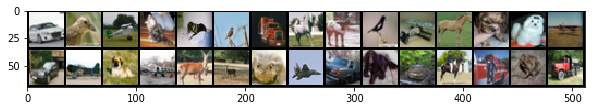

In [264]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils

# 正规化处理所用的参数，必须和训练时相同
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# 变形器组合
transform=transforms.Compose([
    # 必须将 PIL Image 转换为 Tensor，主要是矩阵维度变化，如果是8bit的位图，数值才会除以255，才会保证是在[0,1]之间
    # 否则不会有变化
    transforms.ToTensor(),
#     normalize,   # 我们在后面自己做正规化处理，因为下面需要显示图片
])

# 装载数据到‘数据源对象’
test_sets = datasets.CIFAR10(root='../data', train=False, transform=transform)

# DataLoader 只是简单的规划需要用到的数据的下标，真正的工作都是在 DataSets 对象中做的
# 在 Windows 下，num_workers 只能设置为0或者1，否则会出现内存溢出、耗光，导致执行失败的情况
val_loader = torch.utils.data.DataLoader(test_sets,
        batch_size=30, shuffle=True,
        num_workers=0, pin_memory=False)

val_iter = iter(val_loader)         # 构建一个遍历器
(input, target) = val_iter.next()   # 读取一批输入和标签

print('input', input.size())        # 尺寸是 15x3x32x32
print('target', target.size())      # 尺寸是 [15] 只有 1D 
print('target', target.tolist())    # 显示一下真实类别

def show_images(input):
    """ 显示一组图片 """
    grid = utils.make_grid(input, 15)   # C,H,W
    img = grid.numpy()
    img = img.transpose((1,2,0))  # H,W,C
    plt.figure(figsize=(10, 2))
    plt.imshow(img)

def show_labels(labels, msg="预测的类是："):
    """ 显示类别名称 """
    classes = ('飞机 plane', '汽车 car', '鸟 bird', '猫 cat',
           '鹿 deer', '狗 dog', '青蛙 frog', '马 horse', '轮船 ship', '卡车 truck')
    print(msg)
    print([classes[i] for i in labels])
    
show_images(input)
show_labels(target, '正确标签是：')

# 预处理，很重要
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
for img in input:   # 对每张图都要单独做一次预处理
    for t, m, s in zip(img, mean, std):    # zip 相当于把 C,H,W 和 mean，std 变成了 ({c1,h,w},m1,s1), ({c2,h,w},m2,s2), ({c3,h,w},m3,s3)
        t.sub_(m).div_(s)                  # in-place 减去均值除以标准差

## 预测:

In [244]:
from torch.autograd import Variable

input_var = Variable(input).cuda()         # 把输入包入变量，送到 GPU去
target = target.cuda()                     # 目标也放到 GPU 去，得到一个 torch.cuda.Tensor 对象，方便后面的处理
Y = model(input_var)                       # 做一次前向传播，Y 是一个 Variable
_, pred = Y.topk(1, 1, True, True)         # 找到 top1 最大的下标, 这时 pred 是一个 Variable

# 计算准确率
target = target.view(-1,1)   # 因为 target 是 1D，而 pred 是 2D 所以需要先将 1D 的转换为 2D
print('pred:', type(pred))   # pred 现在还是 Variable
print('target:', type(target))    # target 却是 Tensor
acc = pred.eq(Variable(target))   # 但是 eq 要求参数是 float 或者 Variable
print('accuracy: {:.2f}%'.format(acc.data.sum()/len(acc)*100))
pred = pred.t().cpu().data.tolist()
# Y = np.argmax(Y.data.numpy(), axis=1)
print('真实的类：', target.t().tolist())
print('预测的类：', pred)
show_labels(pred[0], '预测的类名是：')

pred: <class 'torch.autograd.variable.Variable'>
target: <class 'torch.cuda.LongTensor'>
accuracy: 90.00%
真实的类： [[9, 1, 1, 9, 1, 2, 7, 4, 6, 7, 8, 1, 0, 8, 7, 0, 4, 9, 5, 1, 3, 8, 4, 2, 6, 1, 3, 3, 5, 9]]
预测的类： [[9, 1, 1, 9, 1, 2, 7, 4, 6, 2, 8, 1, 0, 8, 7, 0, 4, 9, 3, 1, 3, 8, 4, 2, 6, 1, 3, 3, 5, 2]]
预测的类名是：
['卡车 truck', '汽车 car', '汽车 car', '卡车 truck', '汽车 car', '鸟 bird', '马 horse', '鹿 deer', '青蛙 frog', '鸟 bird', '轮船 ship', '汽车 car', '飞机 plane', '轮船 ship', '马 horse', '飞机 plane', '鹿 deer', '卡车 truck', '猫 cat', '汽车 car', '猫 cat', '轮船 ship', '鹿 deer', '鸟 bird', '青蛙 frog', '汽车 car', '猫 cat', '猫 cat', '狗 dog', '鸟 bird']


## 下面我们用一些网络图片来测试一下，是否能正确识别出来

In [308]:
from PIL import Image
image_files = ['dog.jpg','dog1.jpg','dog2.jpg','catty.jpg','car.jpg','car2.jpg','car3.jpg']
X = torch.zeros((len(image_files),3,32,32))
print(X.shape)

transform=transforms.Compose([
    # 必须将 PIL Image 转换为 Tensor，主要是矩阵维度变化，如果是8bit的位图，数值才会除以255，才会保证是在[0,1]之间
    # 否则不会有变化
    transforms.ToTensor(),
    normalize,
])
for i,img_file in enumerate(image_files):
    img = Image.open('images/'+img_file)
    img = img.resize((32,32))
    img = transform(img)
    X[i] = img
    
X_var = Variable(X).cuda()
Y = model(X_var)
_, pred = Y.topk(1,1)
pred = pred.data.t().tolist()
print(pred)
show_labels(pred[0])

torch.Size([7, 3, 32, 32])
[[7, 5, 5, 3, 0, 1, 1]]
预测的类是：
['马 horse', '狗 dog', '狗 dog', '猫 cat', '飞机 plane', '汽车 car', '汽车 car']
